# Защита персональных данных клиентов

Цель проекта -  защитить данные клиентов страховой компании «Хоть потоп». Необходимо разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию, и обосновать корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

Импортируем необходимые для работы над проектом библиотеки и метрики.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import r2_score
from scipy.spatial import distance

Загрузим данные и изучим их.

In [2]:
data = pd.read_csv('datasets/insurance.csv')

In [3]:
display(data.head(10))
display(data.info())
display(data.describe().transpose())

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
5,1,43.0,41000.0,2,1
6,1,39.0,39700.0,2,0
7,1,25.0,38600.0,4,0
8,1,36.0,49700.0,1,0
9,1,32.0,51700.0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None

,count,mean,std,min,25%,50%,75%,max
Пол,5000.0,0.4990,0.500049,0.0,0.0,0.0,1.0,1.0
Возраст,5000.0,30.9528,8.440807,18.0,24.0,30.0,37.0,65.0
Зарплата,5000.0,39916.3600,9900.083569,5300.0,33300.0,40200.0,46600.0,79000.0
Члены семьи,5000.0,1.1942,1.091387,0.0,0.0,1.0,2.0,6.0
Страховые выплаты,5000.0,0.1480,0.463183,0.0,0.0,0.0,0.0,5.0


Всего в датасете 5000 записей, пропущенных значений нет, пол клиентов распределен примерно пополам, в столбцах с информацией о вохрасте, зарплате, количестве членов семьи и количестве страховых выплат нет явнях выбросов.

Проанализируем распределение количественных значений в столбцах.

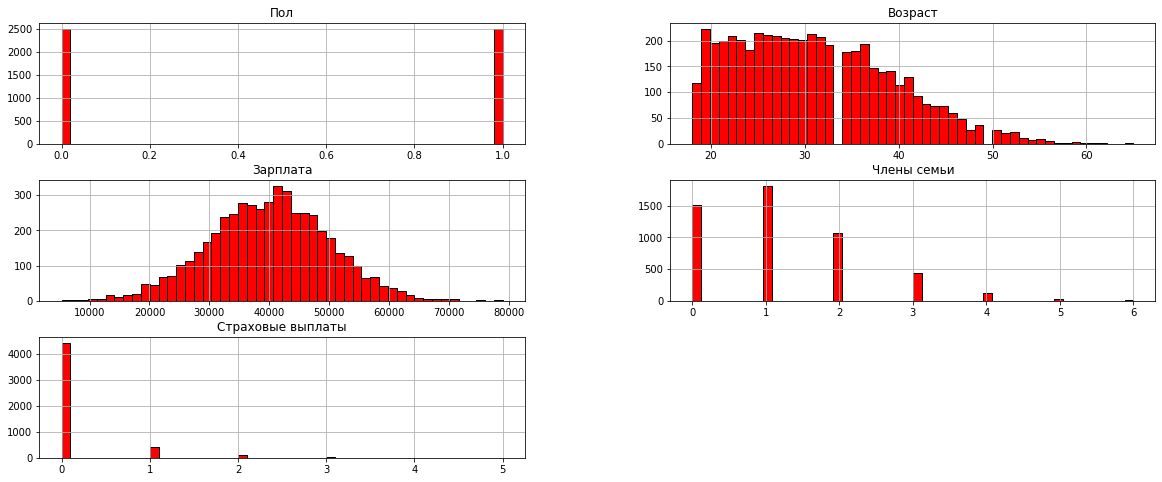

In [4]:
data.hist(bins=50, figsize=(20,8), color='r', edgecolor='black', linewidth=1)
plt.show()

Как и было сказано выше, пол распределен примерно пополам, распределение зарплаты клиентов носит вид, близкий к нормальному, со средним в районе 40000, возраст в интервале от 18 до 35 распределен практически непрерывно, далее- по убывающей. У подавляющего большинства клиентов не было страховых выплат, поэтому результаты обучения модели на несбалансированных данных по целевому признаку могут быть недостаточно хороши.

Также видим, что столбцы 'Возраст' и 'Зарплата' имеют вещественный тип данных. Для столбца с возрастом проверим, можем ли без ущерба для данных перевести его в целочисленный- выведем на экран гистограмму дробной части всех записей в столбце.

<AxesSubplot:>

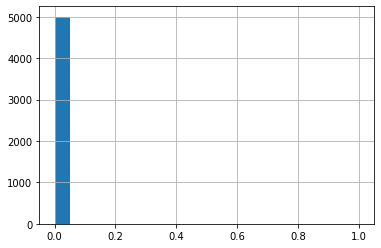

In [5]:
(data['Возраст'] % 1).hist(range=(0,1), bins=20)

Видим, что в столбце с возрастом клиентов нет записей с дробной частью, поэтому можем перевести данные в целочисленный формат (int8), а в столбце с зарплатой данные можно округлить без большой погрешности, так как числа в нем довольно большие. В столбце с зарплатой данные переведем в int32. Столбцы с полом, количеством членов семьи и страховых выплат также переведем в int8, чтобы они занимали меньше места.

In [6]:
for column in ['Пол', 'Возраст', 'Члены семьи', 'Страховые выплаты']:
    data[column] = data[column].astype('int8')

data['Зарплата'] = data['Зарплата'].astype('int32')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Пол                5000 non-null   int8 
 1   Возраст            5000 non-null   int8 
 2   Зарплата           5000 non-null   int32
 3   Члены семьи        5000 non-null   int8 
 4   Страховые выплаты  5000 non-null   int8 
dtypes: int32(1), int8(4)
memory usage: 39.2 KB


In [7]:
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41,49600,1,0
1,0,46,38000,1,1
2,0,29,21000,0,0
3,0,21,41700,2,0
4,1,28,26100,0,0


Изменили тип данных на целочисленный во всех столбцах. 

Проверим, нет ли мультиколлинеарности признаков. Для этого построим матрицу корреляции.

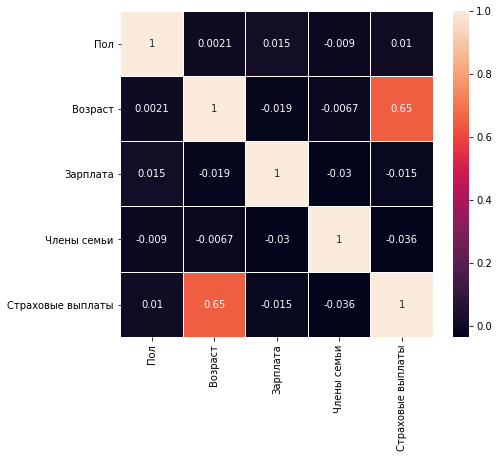

In [8]:
correlation = data.corr()
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(correlation, annot=True, linewidths=.1, ax=ax)
plt.show()

Видим среднюю корреляцию целевого признака с возрастом клиента.

### Вывод

В данном разделе проекта открыли и проанализировали данные о клиентах страховой компании. Пропусков в данных нет, выбросов также нет. 

Данные можно считать подготовленными для машинного обучения.

## Умножение матриц

Выделим в отдельные переменные обучающие признаки и целевой признак- количество страховых выплат клиентов.

In [9]:
features = data.drop('Страховые выплаты', axis=1)
target = data['Страховые выплаты']

Создадим класс линейной регрессии, в котором напишем функции обучения и предсказания. Обучение будет производить путем матричного умножения по формуле:
$$
w = (X^T X)^{-1} X^T y
$$

где  $X$ — матрица признаков (нулевой столбец состоит из единиц), $y$ — вектор целевого признака, $P$ — матрица, на которую умножаются признаки, $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$



In [10]:
class LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0
    
model = LinearRegression()
model.fit(features, target)
predictions = np.round(model.predict(features))

print(r2_score(target, predictions))

0.6270326719379382


**Вопрос:** Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? 

**Ответ:** Не изменится

**Обоснование:** Выпишем отдельно формулы обучения и предсказания:

$$
w = (X^T X)^{-1} X^T y
$$
$$
a = Xw
$$

Подставим $w$ в формулу предсказания:


$$
a = X (X^T X)^{-1} X^T y
$$

Домножим матрицу признаков на невырожденную матрицу $A$ (определитель такой матрицы не равен нулю) и запишем формулу предсказания для матрицы $X*A$.

$$
a_1 = (X*A) ((X*A)^T (X*A))^{-1} (X*A)^T y
$$

Раскроем скобки и с помощью преобразований $(X*A)^T=A^T*X^T$ и $(X*A)^{-1}=A^{-1}*X^{-1}$ получим уравнение следующего вида:

$$
a_1 = (X*A) (A^T (X^T X) A )^{-1} (X*A)^T y
$$

$$
a_1 = X A A^{-1} (X^T X)^{-1} (A^T)^{-1} A^T X^T y
$$

Умножения вида $A * A^{-1}$ и $A^T * (A^T)^{-1}$ дают нам единичные матрицы, которые можно сократить. Итого имеем выражение:

$$
a_1 = X (X^T X)^{-1} X^T y
$$

И окончательно:

$$
a_1 = a
$$

## Алгоритм преобразования

**Алгоритм**

Так как умножение на невырожденную матрицу не изменяет результаты прогноза линейной регрессии, напишем класс прямого и обратного преобразования, в котором создадим функцию преобразования признаков по следующему алгоритму:

1. Сгенерируем матрицу размера $n*n$, где $n$- количество обучающих признаков.
2. Вычислим определитель матрицы и сравним его с нулем.
3. Если определитель не равен нулю, умножим матрицу признаков на созданную матрицу. Если определитель равен нулю, то будем создавать матрицу до момента, пока ее определитель не станет отличным от нуля.
4. Функция возвращает преобразованную матрицу обучающих признаков.

Также внутри класса создадим функцию преобразования к исходной матрице. Для этого преобразованную матрицу умножим на обратную матрицу к случайной.

In [11]:
class Encrypt:
    def transform_features(self, features):
        n = features.shape[1]
        determinant = 0
        np.random.seed(12345)
        while determinant == 0:
            random_matrix = np.random.randint(1, 10,(n,n))
            determinant = np.linalg.det(random_matrix)
            self.random_matrix = random_matrix
        return features @ random_matrix
    def retransform(self, new_features):
        return new_features.dot(np.linalg.inv(self.random_matrix)).round().astype('int32')

**Обоснование**

Чтобы получить матрицу размера $M*N$ при умножении исходной матрицы размера $M*N$ на невырожденную матрицу $A$, матрица $A$ должна быть квадратной размера $N*N$.

## Проверка алгоритма

Проверим наш алгоритм. Преобразуем обучающие признаки, обучим модель линейной регрессии, предскажем результат, вычислим R2 и сравним его значение с полученным при обучении на непреобразованных признаках.

In [12]:
encryptor = Encrypt()
new_features = encryptor.transform_features(features)
model.fit(new_features, target)
predictions = np.round(model.predict(new_features))

print(r2_score(target, predictions))

0.6270326719379382


Значение $R^2$ при обучении на преобразованных признаках равно значению $R^2$ при обучении на оригинальном датасете. Таким образом, работоспособность алгоритма преобразования данных доказана. Также для проверки отобразим на экране количественные значения признаков, чтобы проверить, возможно ли по ним восстановить информацию о клиенте.

In [13]:
new_features

,0,1,2,3
0,99452,396931,347287,49899
1,76279,304140,266095,38329
2,42174,168087,147058,21203
3,83532,333667,291948,41861
4,52371,208890,182758,26301
...,...,...,...,...
4995,71574,285688,249962,35910
4996,105007,419304,366871,52645
4997,67926,271264,237346,34054
4998,65544,261678,228955,32880


Видим, что по преобразованным признакам невозможно восстановить какую-либо информацию без доступа к матрице, на которую была умножена оригинальная матрица признаков. При этом сама матрица в явном виде также не отображается в коде и формируется случайным образом.

Для тестирования всех функций класса шифровщика попробуем расшифровать признаки обратно и сравним первые строки с исходными данными.

In [14]:
encryptor.retransform(new_features)

,0,1,2,3
0,1,41,49600,1
1,0,46,38000,1
2,0,29,21000,0
3,0,21,41700,2
4,1,28,26100,0
...,...,...,...,...
4995,0,28,35700,2
4996,0,34,52400,1
4997,0,20,33900,2
4998,1,22,32700,3


Видим, что функция дешифровки также работает.

## Вывод

В данном проекте предложили и математически доказали корректность алгоритма преобразования данных для защиты клиентов страховой компании. Алгоритм заключается в умножении обучающих признаков на невырожденную матрицу. При умножении на матрицу восстановить информацию о клиентах невозможно, а качество обучения модели линейной регрессии при этом не снижается. Таким образом, можно считать проект выполненным.